In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline, CubicSpline, RegularGridInterpolator, RectBivariateSpline, bisplrep
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Am_line = source_dict['Am241']

# plot_dir = '/home/cosilab/CalibrationData/figures/'
plot_dir = '/Users/sean/Desktop/trapping_figures/'
datpath = '/Users/sean/COSI/calibration_data/UCSD_spare/'
# datpath = '/home/CalibrationData/CalibratedDATs/'

sim_dCCE_path = '/Users/sean/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'
sim_dCCE = np.loadtxt(sim_dCCE_path, delimiter=',').T
depth_grid = sim_dCCE[0]

### In these, b=electron trapping, c=hole trapping
def e_cce(b, c):
    ### electron-dominated signal
    return (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
def h_cce(b, c):
    ### hole-dominated signal
    return (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])

In [3]:
gain_factor_map = np.ones((2,37))
with open('/Users/sean/Desktop/nuclearizer_test/20231107_Am241_Ba133_Cs137_Na22.ecal', 'r') as file:
    for line in file:
        splitline = line.split()
        if len(splitline):
            if splitline[0]=='CP':
                PH = float(splitline[7])
            if splitline[0]=='CM':
                strip = int(splitline[3])-1
                poly_gain_E = 0.0
                for i in range(4):
                    poly_gain_E += float(splitline[6+i])*(PH**i)
                if splitline[4]=='p':
                    gain_factor_map[0][strip] = Am_line/poly_gain_E
                elif splitline[4]=='n':
                    gain_factor_map[1][strip] = Am_line/poly_gain_E

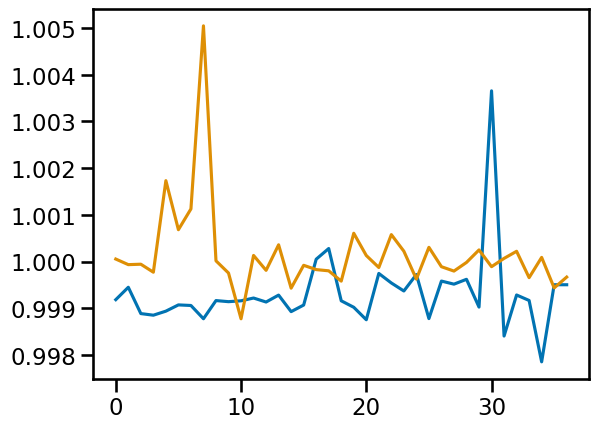

In [4]:
plt.figure()
plt.plot(range(37), gain_factor_map[0])
plt.plot(range(37), gain_factor_map[1])
plt.show()

# Pre LL

In [5]:
files = [['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat'], \
                      ['20230922_Am241_DC_600V_1.dat', '20230922_Am241_DC_600V_2.dat']]

erange = [50., 64.]

emin = erange[0]
emax = erange[1]
bins = int((emax-emin) * 4)

AC_centroid_map = np.zeros((2, 37, 37))
DC_centroid_map = np.zeros_like(AC_centroid_map)

fullpaths = []
for p in files[0]:
    fullpaths.append(datpath + 'preLL/' + p)

df_AC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

fullpaths = []
for p in files[1]:
    fullpaths.append(datpath + 'preLL/' + p)

df_DC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

In [6]:
for p in range(37):
    for n in range(37):
            AC_sliced = df_AC.loc[(df_AC['strip_p']==p+1) & (df_AC['strip_n']==n+1)]
            DC_sliced = df_DC.loc[(df_DC['strip_p']==p+1) & (df_DC['strip_n']==n+1)]
            
            if (len(AC_sliced) > 1000) & (len(DC_sliced) > 1000):
                
                for i, side in enumerate(['p','n']):
                    energies = AC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    gain_factor = 1.0
                    if side=='p':
                        gain_factor = gain_factor_map[i][p]
                    elif side=='n':
                        gain_factor = gain_factor_map[i][n]
                    AC_centroid_map[i][p][n] = m.values['x0']*gain_factor
                    
                    energies = DC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    DC_centroid_map[i][p][n] = m.values['x0']*gain_factor
    

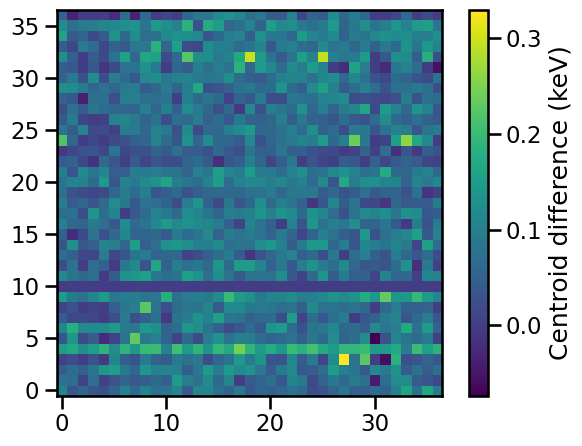

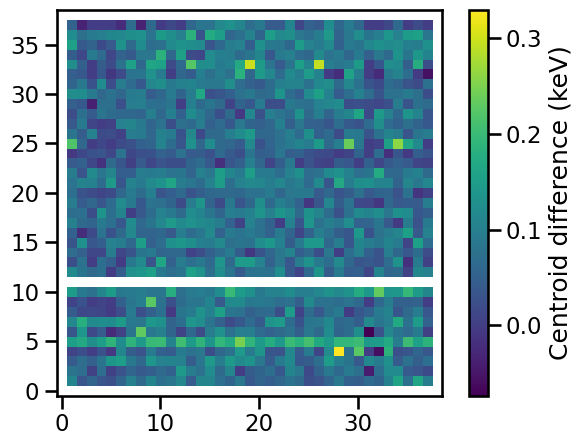

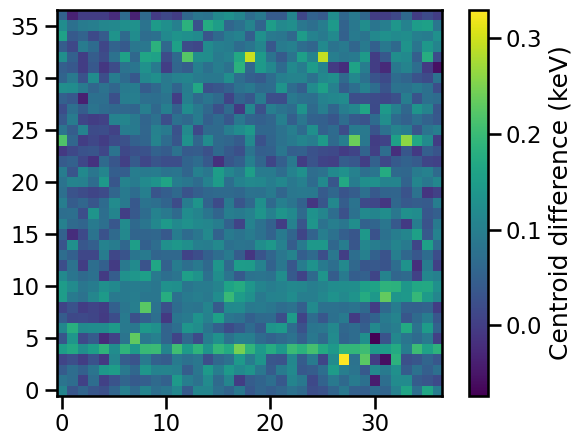

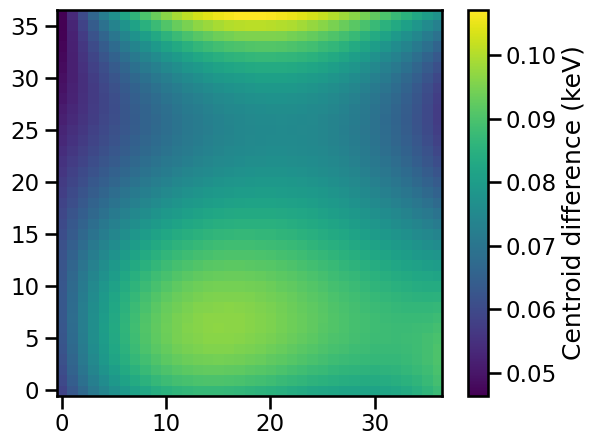

In [7]:
diff_map_buff = np.ones((39,39)) * -10.
diff_map_buff[1:38,1:38] = DC_centroid_map[1] - AC_centroid_map[1]
# diff_map_buff[3:4,:] = 0.0
# diff_map_buff[5:6,:] = 0.0
# diff_map_buff[11:12,:] = -10.0
# diff_map_buff[31:32,:] = 0.0
diff_map_buff[:,11:12] = -10.0
# diff_map_buff[:,25:26] = 0.0
diff_map_buff = np.ma.masked_less(diff_map_buff, -1.0)
centroid_diff_map = DC_centroid_map[1] - AC_centroid_map[1]
mask = np.ma.getmask(diff_map_buff)
for i in range(37):
    for j in range(37):
        if mask[i+1,j+1]:
            centroid_diff_map[i,j] = np.mean(diff_map_buff[i:i+2, j:j+2])
centroid_diff_map_spline_h = RectBivariateSpline(range(37), range(37), centroid_diff_map, s=8)
# print(centroid_diff_map_spline_h(0,1))

plt.figure()
plt.imshow((DC_centroid_map[1] - AC_centroid_map[1]).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(diff_map_buff.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
# plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map_spline_h(range(37),range(37)).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_smoothmap_holes.pdf')
plt.show()

# plt.figure()
# plt.hist(centroid_diff_map.flatten(), bins = 30)
# plt.ylabel('Pixels')
# plt.xlabel('Centroid difference (keV)')
# plt.tight_layout()
# plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_hist_holes.pdf')

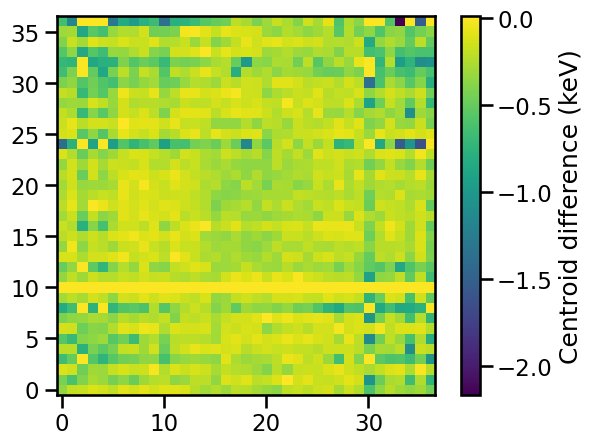

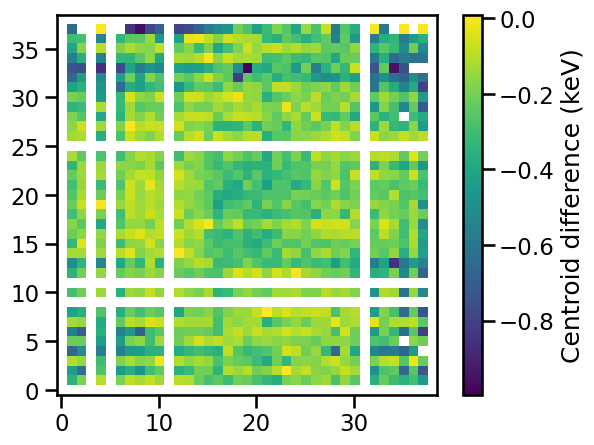

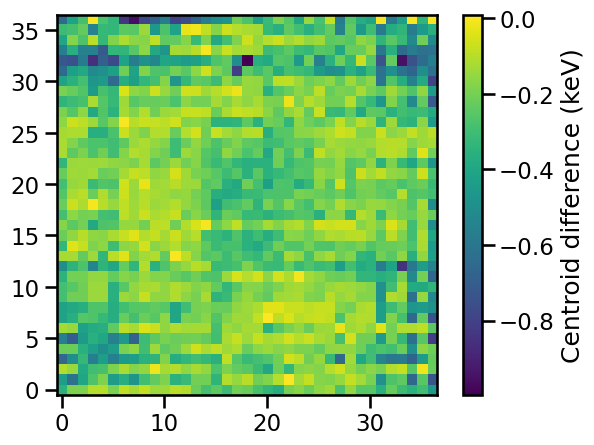

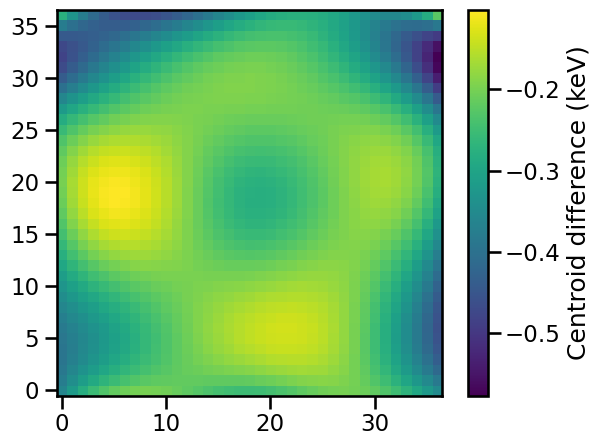

In [8]:
diff_map_buff = np.ones((39,39)) * -10.
diff_map_buff[1:38,1:38] = DC_centroid_map[0] - AC_centroid_map[0]
diff_map_buff[3:4,:] = -10.0
diff_map_buff[5:6,:] = -10.0
diff_map_buff[11:12,:] = -10.0
diff_map_buff[31:32,:] = -10.0
diff_map_buff[:,9:10] = -10.0
diff_map_buff[:,11:12] = -10.0
diff_map_buff[:,25:26] = -10.0
diff_map_buff = np.ma.masked_less(diff_map_buff, -1.)
centroid_diff_map = DC_centroid_map[0] - AC_centroid_map[0]
mask = np.ma.getmask(diff_map_buff)
for i in range(37):
    for j in range(37):
        if mask[i+1,j+1]:
            centroid_diff_map[i,j] = np.mean(diff_map_buff[i:i+2, j:j+2])
centroid_diff_map_spline_e = RectBivariateSpline(range(37), range(37), centroid_diff_map, s=20)
# print(centroid_diff_map_spline_h(0,1))

plt.figure()
plt.imshow((DC_centroid_map[0] - AC_centroid_map[0]).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_electrons.pdf')
plt.show()

plt.figure()
plt.imshow(diff_map_buff.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
# plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
# plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map_spline_e(range(37),range(37)).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_smoothmap_electrons.pdf')
plt.show()

# plt.figure()
# plt.hist(centroid_diff_map.flatten(), bins = 30)
# plt.ylabel('Pixels')
# plt.xlabel('Centroid difference (keV)')
# plt.tight_layout()
# plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_hist_holes.pdf')

## Reading in simulations and getting trapping product vs. shift

In [9]:
mfp = 0.09476 # cm
depth_prob = np.exp(-depth_grid/mfp)
n_events = 100000

def depth_cdf(z, mfp):
    return (1./mfp)*(1.-np.exp(-z/mfp))

def inv_cdf(y, mfp, max_depth = 1.51):
    N = (1./mfp)*(1.-np.exp(-max_depth/mfp))
    return mfp*np.log(1.0/(1.0-N*mfp*y))

eprod_grid = np.linspace(0.1, 5.0, num = 25)
hprod_grid = np.linspace(0.1, 5.0, num = 25)

ediff_grid = np.zeros((len(eprod_grid), len(hprod_grid)))
hdiff_grid = np.zeros((len(eprod_grid), len(hprod_grid)))

for i in range(len(eprod_grid)):
    for j in range(len(hprod_grid)):
        random_depths_DC = inv_cdf(np.random.random(size = n_events), mfp)
        random_depths_AC = inv_cdf(np.random.random(size = n_events), -mfp)
        Eh_z = CubicSpline(depth_grid, Am_line*h_cce(eprod_grid[i], hprod_grid[j]))
        Ee_z = CubicSpline(depth_grid, Am_line*e_cce(eprod_grid[i], hprod_grid[j]))
        random_Eh_AC = Eh_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Eh_DC = Eh_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Ee_AC = Ee_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Ee_DC = Ee_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        ediff_grid[i,j] = np.mean(random_Ee_DC) - np.mean(random_Ee_AC)
        hdiff_grid[i,j] = np.mean(random_Eh_DC) - np.mean(random_Eh_AC)

0.04770442921231677
-0.234880676518479


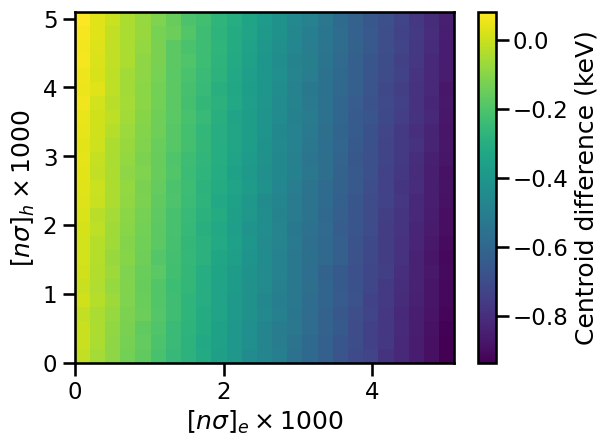

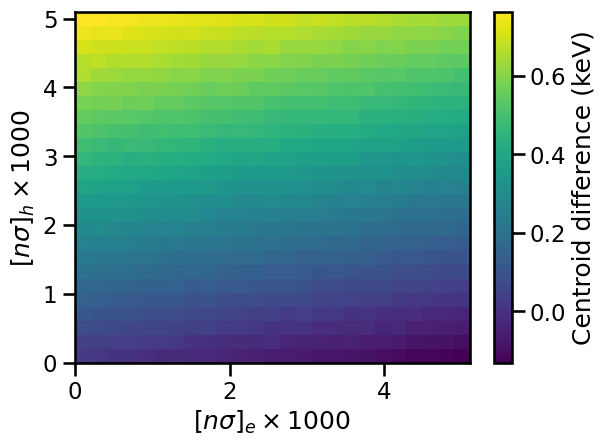

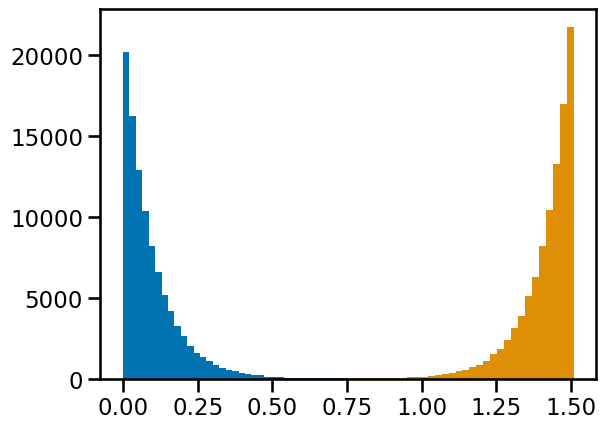

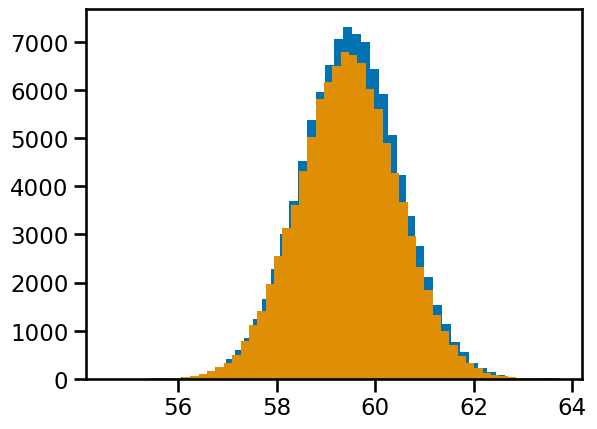

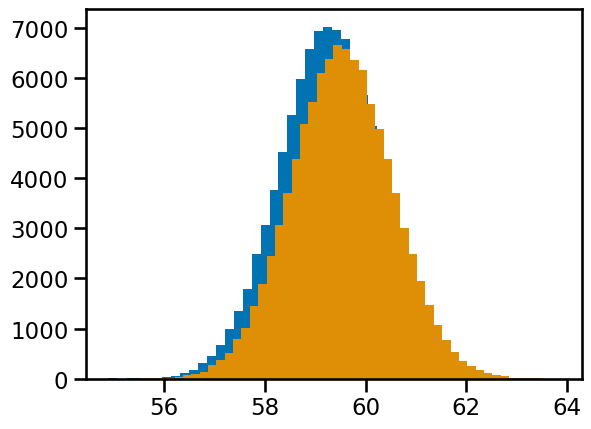

In [10]:
plt.figure()
plt.pcolormesh(*np.meshgrid(eprod_grid, hprod_grid, indexing='ij'), ediff_grid)
plt.xlabel(r'$[n\sigma]_{e} \times 1000$')
plt.ylabel(r'$[n\sigma]_{h} \times 1000$')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/trappingprod_to_ediff_grid.pdf')

plt.figure()
plt.pcolormesh(*np.meshgrid(eprod_grid, hprod_grid, indexing='ij'), hdiff_grid)
plt.xlabel(r'$[n\sigma]_{e} \times 1000$')
plt.ylabel(r'$[n\sigma]_{h} \times 1000$')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/trappingprod_to_hdiff_grid.pdf')

random_depths_AC = inv_cdf(np.random.random(size = n_events), mfp)
random_depths_DC = inv_cdf(np.random.random(size = n_events), -mfp)
Eh_z = CubicSpline(depth_grid, Am_line*h_cce(1.3, 0.540))
random_Eh_AC = Eh_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
random_Eh_DC = Eh_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)

Ee_z = CubicSpline(depth_grid, Am_line*e_cce(1.3, 0.540))
random_Ee_AC = Ee_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
random_Ee_DC = Ee_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)

print(np.mean(random_Eh_AC) - np.mean(random_Eh_DC))
print(np.mean(random_Ee_AC) - np.mean(random_Ee_DC))

plt.figure()
plt.hist(random_depths_AC, bins = 50)
plt.hist(random_depths_DC, bins = 50)
plt.show()

plt.figure()
plt.hist(random_Eh_AC, bins = 50)
plt.hist(random_Eh_DC, bins = 50)
plt.show()

plt.figure()
plt.hist(random_Ee_AC, bins = 50)
plt.hist(random_Ee_DC, bins = 50)
plt.show()


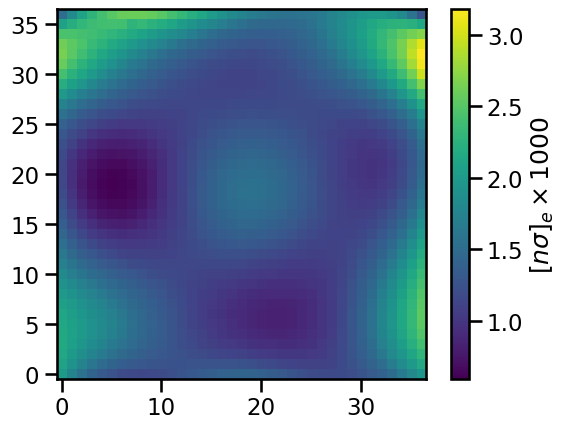

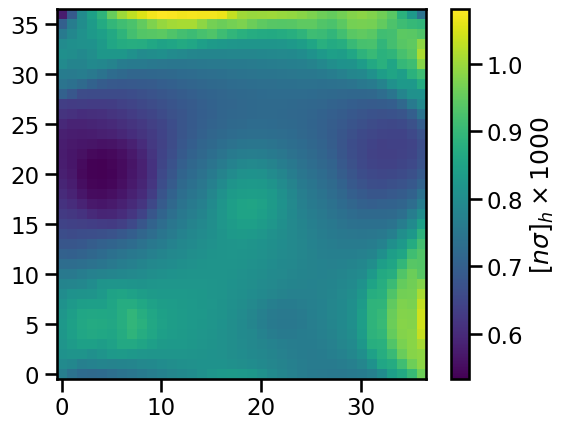

In [11]:
### Next, interpolate both grids, and fit measured differences using the interpolations to get the trapping products.
hdiff_interp = RegularGridInterpolator((eprod_grid, hprod_grid), hdiff_grid)
ediff_interp = RegularGridInterpolator((eprod_grid, hprod_grid), ediff_grid)

eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=0.540)
        m.limits['eprod']=(np.min(eprod_grid), np.max(eprod_grid))
        m.limits['hprod']=(np.min(hprod_grid), np.max(hprod_grid))
        m.migrad()
        # m.hesse()

        eprod_map[i,j] = m.values['eprod']
        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(eprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{e} \times 1000$')
plt.savefig(plot_dir + 'preLL/trapping_prod_map_electrons.pdf')

plt.figure()
plt.imshow(hprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{h} \times 1000$')
plt.savefig(plot_dir + 'preLL/trapping_prod_map_holes.pdf')

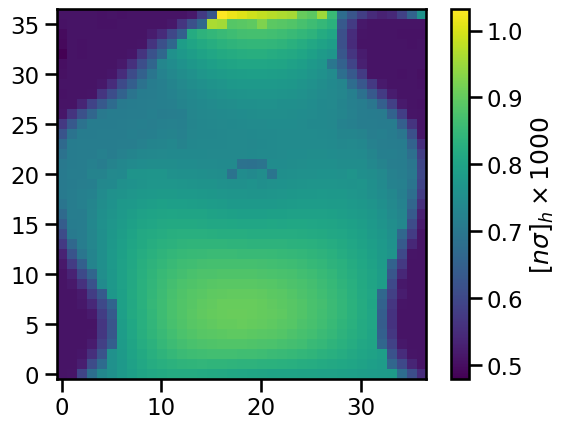

In [12]:
eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=0.540)
        m.fixed['eprod'] = True
        m.limits['hprod']=(np.min(hprod_grid), np.max(hprod_grid))
        m.migrad()
        # m.hesse()

        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(hprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{h} \times 1000$')
plt.savefig(plot_dir + 'preLL/trapping_prod_map_holes_etrapfixed.pdf')

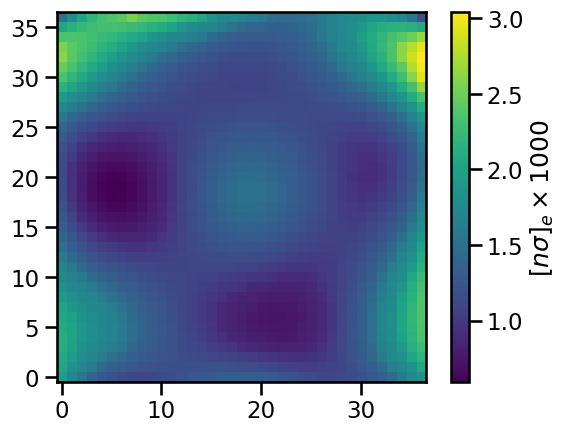

In [13]:
eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=0.540)
        m.limits['eprod']=(np.min(eprod_grid), np.max(eprod_grid))
        m.fixed['hprod'] = True
        m.migrad()
        # m.hesse()

        eprod_map[i,j] = m.values['eprod']
        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(eprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{e} \times 1000$')
plt.savefig(plot_dir + 'preLL/trapping_prod_map_electrons_htrapfixed.pdf')

eprod_map_preLL = eprod_map

# Post LL1

In [14]:
files = [['20231103_Am241_AC_600V.dat', '20231109_Am241_AC_600V.dat'], \
         ['20231103_Am241_DC_600V_1.dat', '20231108_Am241_DC_600V_1.dat', '20231103_Am241_DC_600V_2.dat', '20231108_Am241_DC_600V_2.dat']]

erange = [50., 64.]

emin = erange[0]
emax = erange[1]
bins = int((emax-emin) * 4)

AC_centroid_map = np.zeros((2, 37, 37))
DC_centroid_map = np.zeros_like(AC_centroid_map)

fullpaths = []
for p in files[0]:
    fullpaths.append(datpath + 'postLL1/' + p)

df_AC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

fullpaths = []
for p in files[1]:
    fullpaths.append(datpath + 'postLL1/' + p)

df_DC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

In [15]:
for p in range(37):
    for n in range(37):
            AC_sliced = df_AC.loc[(df_AC['strip_p']==p+1) & (df_AC['strip_n']==n+1)]
            DC_sliced = df_DC.loc[(df_DC['strip_p']==p+1) & (df_DC['strip_n']==n+1)]
            
            if (len(AC_sliced) > 1000) & (len(DC_sliced) > 1000):
                
                for i, side in enumerate(['p','n']):
                    energies = AC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)

                    gain_factor = 1.0
                    if side=='p':
                        gain_factor = gain_factor_map[i][p]
                    elif side=='n':
                        gain_factor = gain_factor_map[i][n]

                    AC_centroid_map[i][p][n] = m.values['x0']*gain_factor
                    
                    energies = DC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    DC_centroid_map[i][p][n] = m.values['x0']*gain_factor
    

/Users/sean/COSITrapping/depth_helpers.py:56: RuntimeWarning: invalid value encountered in divide
  return gauss_plus_tail(x, BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio)/\
/Users/sean/COSITrapping/depth_helpers.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]
/Users/sean/COSITrapping/depth_helpers.py:57: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

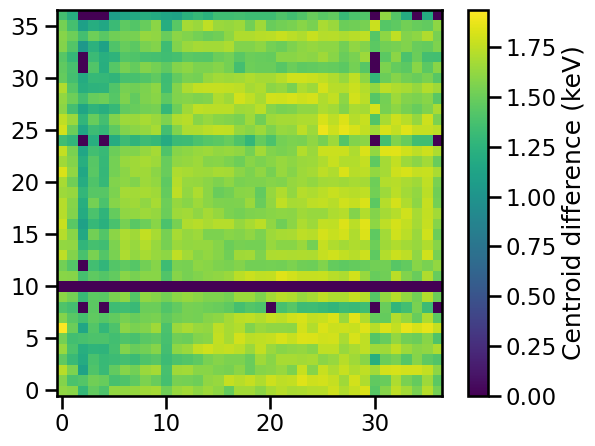

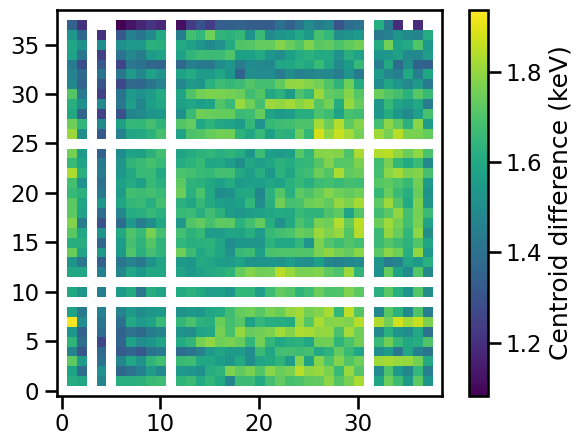

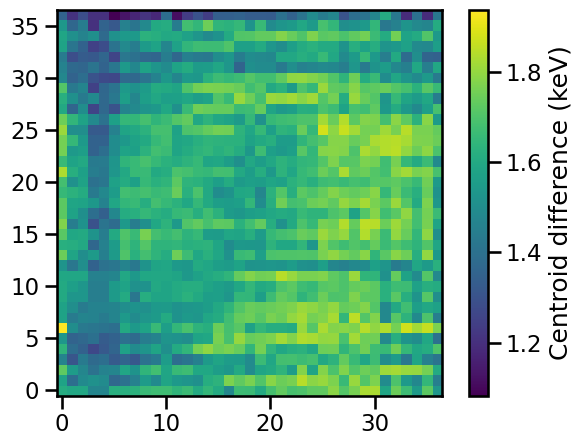

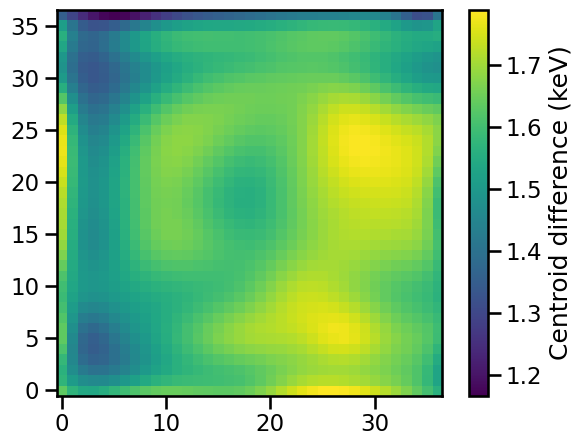

In [16]:
diff_map_buff = np.zeros((39,39))
diff_map_buff[1:38,1:38] = DC_centroid_map[1] - AC_centroid_map[1]
diff_map_buff[3:4,:] = 0.0
diff_map_buff[5:6,:] = 0.0
diff_map_buff[11:12,:] = 0.0
diff_map_buff[31:32,:] = 0.0
diff_map_buff[:,9:10] = 0.0
diff_map_buff[:,25:26] = 0.0
diff_map_buff = np.ma.masked_outside(diff_map_buff, 0.1,2.3)
centroid_diff_map = DC_centroid_map[1] - AC_centroid_map[1]
mask = np.ma.getmask(diff_map_buff)
for i in range(37):
    for j in range(37):
        if mask[i+1,j+1]:
            centroid_diff_map[i,j] = np.mean(diff_map_buff[i:i+2, j:j+2])
centroid_diff_map_spline_h = RectBivariateSpline(range(37), range(37), centroid_diff_map, s=8)
# print(centroid_diff_map_spline_h(0,1))

plt.figure()
plt.imshow((DC_centroid_map[1] - AC_centroid_map[1]).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes.pdf')
plt.show()

plt.figure()
plt.imshow(diff_map_buff.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes_masked.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes_interp.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map_spline_h(range(37),range(37)).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_smoothmap_holes.pdf')
plt.show()

# plt.figure()
# plt.hist(centroid_diff_map.flatten(), bins = 30)
# plt.ylabel('Pixels')
# plt.xlabel('Centroid difference (keV)')
# plt.tight_layout()
# plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_hist_holes.pdf')

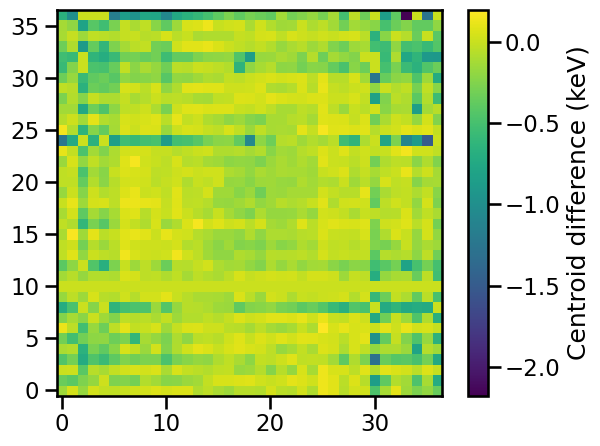

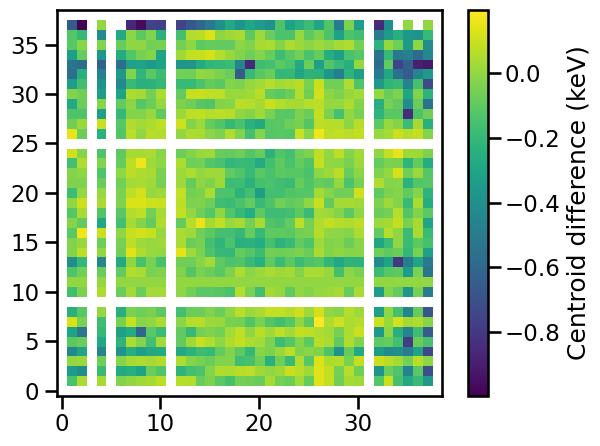

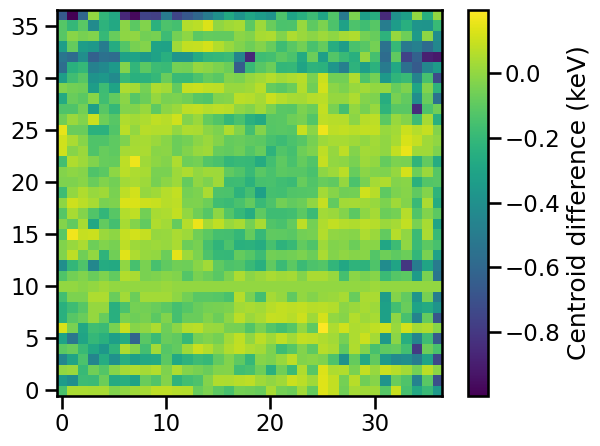

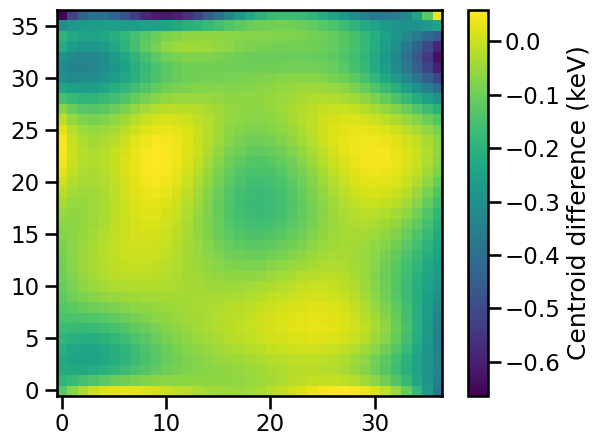

In [17]:
diff_map_buff = np.ones((39,39)) * -10.
diff_map_buff[1:38,1:38] = DC_centroid_map[0] - AC_centroid_map[0]
diff_map_buff[3:4,:] = -10.0
diff_map_buff[5:6,:] = -10.0
diff_map_buff[11:12,:] = -10.0
diff_map_buff[31:32,:] = -10.0
diff_map_buff[:,9:10] = -10.0
diff_map_buff[:,25:26] = -10.0
diff_map_buff = np.ma.masked_less(diff_map_buff, -1.)
centroid_diff_map = DC_centroid_map[0] - AC_centroid_map[0]
mask = np.ma.getmask(diff_map_buff)
for i in range(37):
    for j in range(37):
        if mask[i+1,j+1]:
            centroid_diff_map[i,j] = np.mean(diff_map_buff[i:i+2, j:j+2])
centroid_diff_map_spline_e = RectBivariateSpline(range(37), range(37), centroid_diff_map, s=20)
# print(centroid_diff_map_spline_h(0,1))

plt.figure()
plt.imshow((DC_centroid_map[0] - AC_centroid_map[0]).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_electrons.pdf')
plt.show()

plt.figure()
plt.imshow(diff_map_buff.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes_mask.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes_interp.pdf')
plt.show()

plt.figure()
plt.imshow(centroid_diff_map_spline_e(range(37),range(37)).T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_smoothmap_electrons.pdf')
plt.show()

# plt.figure()
# plt.hist(centroid_diff_map.flatten(), bins = 30)
# plt.ylabel('Pixels')
# plt.xlabel('Centroid difference (keV)')
# plt.tight_layout()
# plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_hist_holes.pdf')

## Reading in simulations and getting trapping product vs. shift

In [18]:
mfp = 0.09476 # cm
depth_prob = np.exp(-depth_grid/mfp)
n_events = 100000

def depth_cdf(z, mfp):
    return (1./mfp)*(1.-np.exp(-z/mfp))

def inv_cdf(y, mfp, max_depth = 1.51):
    N = (1./mfp)*(1.-np.exp(-max_depth/mfp))
    return mfp*np.log(1.0/(1.0-N*mfp*y))

eprod_grid = np.linspace(0.1, 5.0, num = 25)
hprod_grid = np.linspace(5.0, 15.0, num = 25)

ediff_grid = np.zeros((len(eprod_grid), len(hprod_grid)))
hdiff_grid = np.zeros((len(eprod_grid), len(hprod_grid)))

for i in range(len(eprod_grid)):
    for j in range(len(hprod_grid)):
        random_depths_DC = inv_cdf(np.random.random(size = n_events), mfp)
        random_depths_AC = inv_cdf(np.random.random(size = n_events), -mfp)
        Eh_z = CubicSpline(depth_grid, Am_line*h_cce(eprod_grid[i], hprod_grid[j]))
        Ee_z = CubicSpline(depth_grid, Am_line*e_cce(eprod_grid[i], hprod_grid[j]))
        random_Eh_AC = Eh_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Eh_DC = Eh_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Ee_AC = Ee_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        random_Ee_DC = Ee_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)
        ediff_grid[i,j] = np.mean(random_Ee_DC) - np.mean(random_Ee_AC)
        hdiff_grid[i,j] = np.mean(random_Eh_DC) - np.mean(random_Eh_AC)

1.4421101751489402
-0.06583678800604531


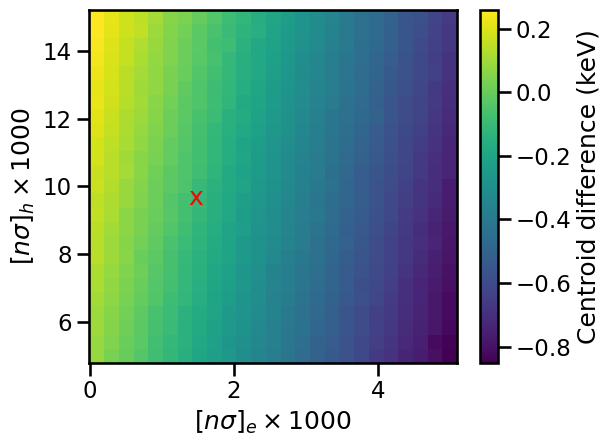

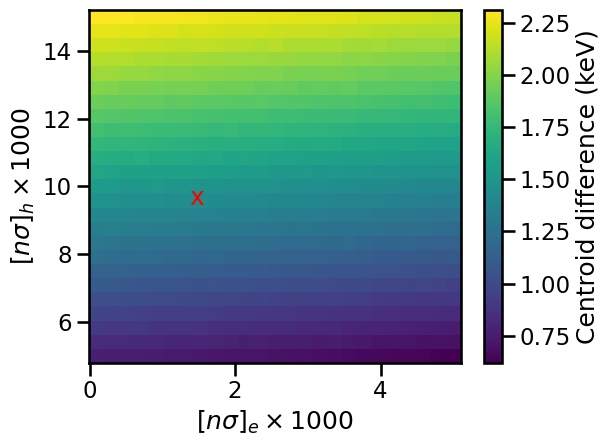

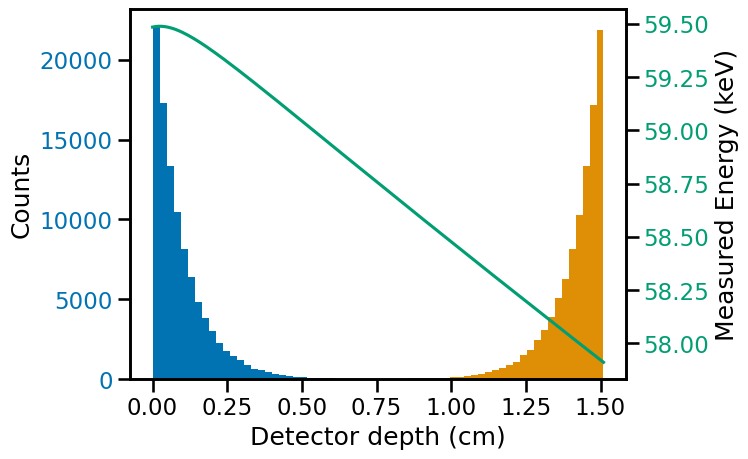

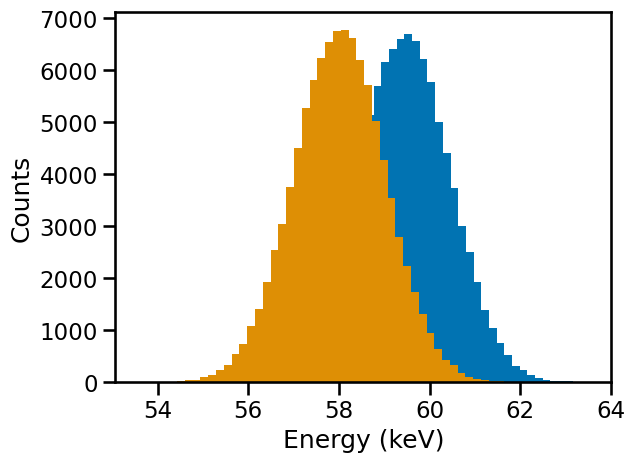

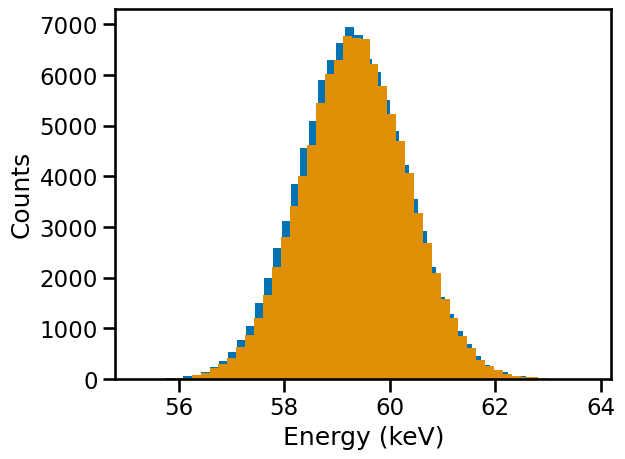

In [19]:
plt.figure()
plt.pcolormesh(*np.meshgrid(eprod_grid, hprod_grid, indexing='ij'), ediff_grid)
plt.xlabel(r'$[n\sigma]_{e} \times 1000$')
plt.ylabel(r'$[n\sigma]_{h} \times 1000$')
plt.text(1.367, 9.463, 'x', color='red')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/trappingprod_to_ediff_grid.pdf')

plt.figure()
plt.pcolormesh(*np.meshgrid(eprod_grid, hprod_grid, indexing='ij'), hdiff_grid)
plt.xlabel(r'$[n\sigma]_{e} \times 1000$')
plt.ylabel(r'$[n\sigma]_{h} \times 1000$')
plt.text(1.367, 9.463, 'x', color='red')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/trappingprod_to_hdiff_grid.pdf')

random_depths_AC = inv_cdf(np.random.random(size = n_events), mfp)
random_depths_DC = inv_cdf(np.random.random(size = n_events), -mfp)
Eh_z = CubicSpline(depth_grid, Am_line*h_cce(1.3, 9.5))
random_Eh_AC = Eh_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
random_Eh_DC = Eh_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)

Ee_z = CubicSpline(depth_grid, Am_line*e_cce(1.3, 9.5))
random_Ee_AC = Ee_z(random_depths_AC) + np.random.normal(loc=0.0, scale=1., size=n_events)
random_Ee_DC = Ee_z(random_depths_DC) + np.random.normal(loc=0.0, scale=1., size=n_events)

print(np.mean(random_Eh_AC) - np.mean(random_Eh_DC))
print(np.mean(random_Ee_AC) - np.mean(random_Ee_DC))

fig, ax1 = plt.subplots()
ax1.hist(random_depths_AC, bins = 50, color='C0')
ax1.hist(random_depths_DC, bins = 50, color='C1')
ax1.set_xlabel('Detector depth (cm)')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='y', labelcolor='C0')
ax2 = ax1.twinx()
ax2.plot(depth_grid, Eh_z(depth_grid), color='C2')
# ax2.plot(depth_grid, Ee_z(depth_grid), color='C2', ls='dotted')
ax2.set_ylabel('Measured Energy (keV)')
ax2.tick_params(axis='y', labelcolor='C2')
plt.show()

plt.figure()
plt.hist(random_Eh_AC, bins = 50, color='C0')
plt.hist(random_Eh_DC, bins = 50, color='C1')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

plt.figure()
plt.hist(random_Ee_AC, bins = 50)
plt.hist(random_Ee_DC, bins = 50)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()


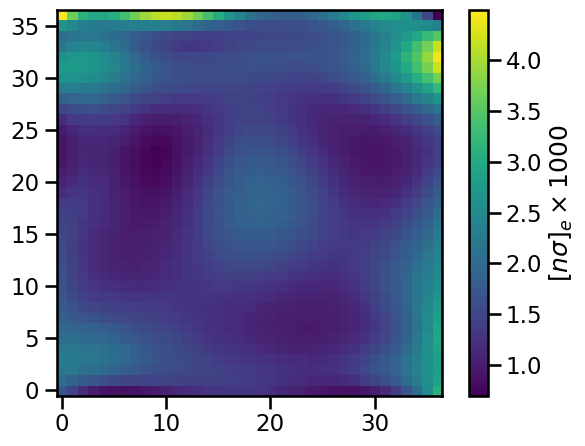

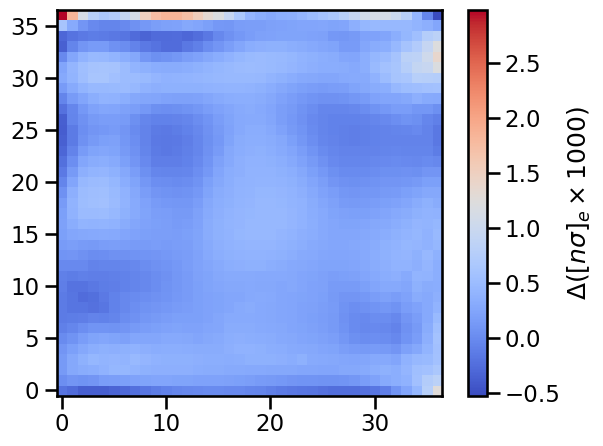

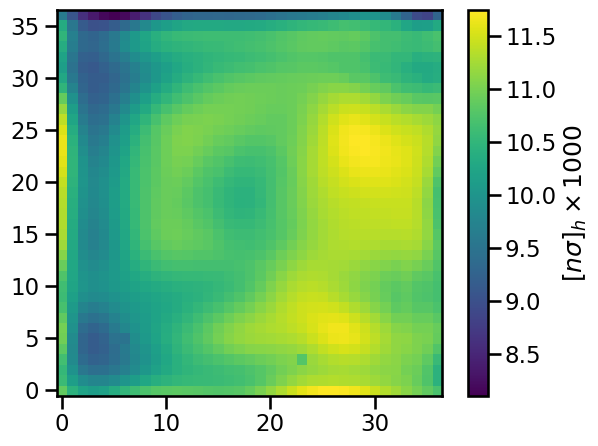

In [20]:
### Next, interpolate both grids, and fit measured differences using the interpolations to get the trapping products.
hdiff_interp = RegularGridInterpolator((eprod_grid, hprod_grid), hdiff_grid)
ediff_interp = RegularGridInterpolator((eprod_grid, hprod_grid), ediff_grid)

eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=9.463)
        m.limits['eprod']=(np.min(eprod_grid), np.max(eprod_grid))
        m.limits['hprod']=(np.min(hprod_grid), np.max(hprod_grid))
        m.migrad()
        # m.hesse()

        eprod_map[i,j] = m.values['eprod']
        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(eprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{e} \times 1000$')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/trapping_prod_map_electrons.pdf')

plt.figure()
plt.imshow((eprod_map - eprod_map_preLL).T, origin='lower', cmap='coolwarm')
plt.colorbar(label=r'$\Delta([n\sigma]_{e} \times 1000)$')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/trapping_prod_map_electrons_change.pdf')

plt.figure()
plt.imshow(hprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{h} \times 1000$')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/trapping_prod_map_holes.pdf')

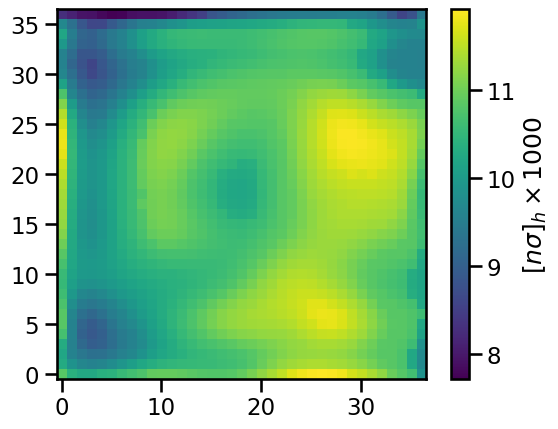

In [21]:
eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=9.463)
        m.fixed['eprod'] = True
        m.limits['hprod']=(np.min(hprod_grid), np.max(hprod_grid))
        m.migrad()
        # m.hesse()

        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(hprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{h} \times 1000$')
plt.savefig(plot_dir + 'postLL1/trapping_prod_map_holes_etrapfixed.pdf')

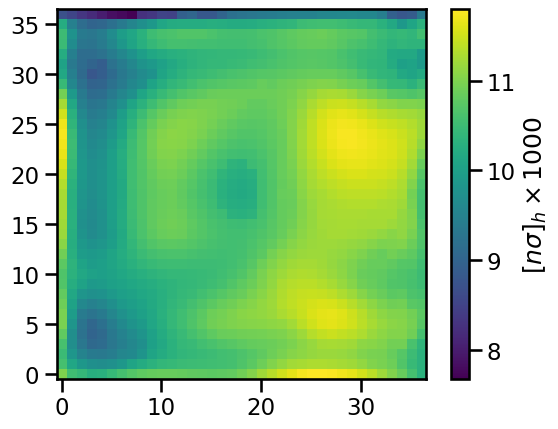

In [22]:
eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

with open('/Users/sean/COSITrapping/UCSDdet_trappingprodmap.txt', 'w') as file:
    
    for i in range(37):
        for j in range(37):
            ediff_obs = centroid_diff_map_spline_e(i,j)
            hdiff_obs = centroid_diff_map_spline_h(i,j)
            def distance(eprod, hprod):
                return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
            # print(eprod_map_preLL[i,j])
            m = Minuit(distance, eprod=eprod_map_preLL[i,j], hprod=9.463)
            m.fixed['eprod'] = True
            m.limits['hprod']=(np.min(hprod_grid), np.max(hprod_grid))
            m.migrad()
            # m.hesse()
    
            hprod_map[i,j] = m.values['hprod']

            file.write('p ' + str(i) + ' n ' +str(j) + ' ' + str(eprod_map_preLL[i,j]) + ' ' + str(m.values['hprod']) + '\n')
    
plt.figure()
plt.imshow(hprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{h} \times 1000$')
plt.savefig(plot_dir + 'postLL1/trapping_prod_map_holes_etrapfixedtopreLL.pdf')

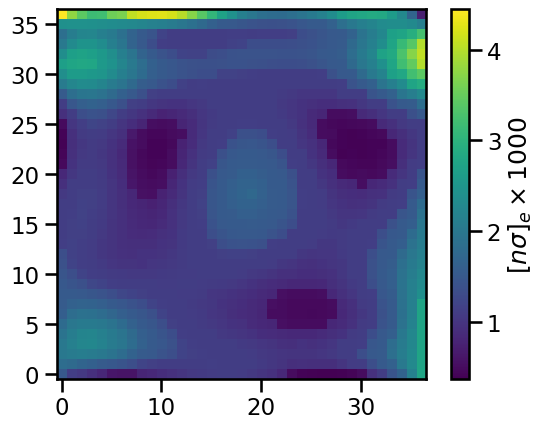

In [23]:
eprod_map = np.zeros(centroid_diff_map.shape)
hprod_map = np.zeros(centroid_diff_map.shape)

for i in range(37):
    for j in range(37):
        ediff_obs = centroid_diff_map_spline_e(i,j)
        hdiff_obs = centroid_diff_map_spline_h(i,j)
        def distance(eprod, hprod):
            return np.sqrt(np.square(ediff_obs - ediff_interp((eprod, hprod))) + np.square(hdiff_obs - hdiff_interp((eprod, hprod))))
        m = Minuit(distance, eprod=1.367, hprod=9.463)
        m.limits['eprod']=(np.min(eprod_grid), np.max(eprod_grid))
        m.fixed['hprod'] = True
        m.migrad()
        # m.hesse()

        eprod_map[i,j] = m.values['eprod']
        hprod_map[i,j] = m.values['hprod']
    
plt.figure()
plt.imshow(eprod_map.T, origin='lower')
plt.colorbar(label=r'$[n\sigma]_{e} \times 1000$')
plt.savefig(plot_dir + 'postLL1/trapping_prod_map_electrons_htrapfixed.pdf')